In [1]:
import pandas as pd
import numpy as np
import glob, os

from seahorse import Graph
from seahorse import constants
constants.SHOWMODE = True

cpal = ["#E7CCB1", "#B5DCDD", "#CE9E5B"]

## Load and work with GTDB metadata

In [2]:
fname = "../tables/gtdb_metadata.tsv.gz"
gtdb_meta = pd.read_csv(fname, sep="\t", compression='gzip')

# Quality and completness filter
gtdb_meta["high_concom"] = (gtdb_meta["checkm_completeness"] > 90) & (gtdb_meta["checkm_contamination"] < 5)

ncbi_translation = {
    'nan': 'Isolate',
    'none': 'Isolate',
    'derived from single cell': 'Isolate',
    'derived from environmental_sample': 'Uncultivated',
    'derived from metagenome': 'Uncultivated'
}

rename_ncbi_category = lambda cat: ncbi_translation[cat]
gtdb_meta["ncbi_genome_category_translation"] = gtdb_meta["ncbi_genome_category"].astype(str).apply(rename_ncbi_category)

def set_qual(row) :
    quality = "NC" if row["high_concom"] else "MEDIUM"
    if row["mimag_high_quality"] == True : quality = "HIGH"
    if row["mimag_low_quality"] == True :  quality = "LOW"
    return quality

gtdb_meta["kind"] = gtdb_meta.apply(set_qual, axis=1)
gtdb_meta = gtdb_meta[["accession", "n50_contigs", "kind", "ncbi_genome_category_translation"]]
gtdb_meta.columns = ["reference", "n50_contigs_gtdb", "qual_gtdb", "cat_gtdb"]
gtdb_meta.head()

/Users/work/anaconda3/envs/graphic/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,reference,n50_contigs_gtdb,qual_gtdb,cat_gtdb
0,GCA_000007185.1,1694969,NC,Isolate
1,GCA_000007345.1,5751492,HIGH,Isolate
2,GCA_000008085.1,490885,MEDIUM,Isolate
3,GCA_000010565.1,3025375,HIGH,Isolate
4,GCA_000011125.1,1669696,NC,Isolate


## Comparison with SPMP genomes based on MASH results

In [3]:
fname = '../tables/gtdb_mash_distances.tsv.gz'
mash = pd.read_csv(fname, sep='\t', compression='gzip', index_col=0)

# We keep only pair with distance < 0.05
mash = mash[mash['distance'] < 0.05]

# We only keep the best distance
mash = mash[mash.groupby("query")["distance"].transform(min) == mash["distance"]]

mash.head()

,reference,query,distance,pvalue,hash
0,GCA_900552455.1,SPMP03_bin.55,0.033384,0,2073/5000
2,GCA_000432375.1,SPMP93_bin.89,0.019313,0,2900/5000
4,GCF_000012845.1,SPMP02_bin.48,0.032273,0,2126/5000
6,GCF_003269275.1,SPMP50_bin.29,0.010047,0,3707/5000
8,GCF_001025135.1,SPMP106_bin.22,0.009558,0,3758/5000


## Merge all together

In [4]:
fname = '../tables/mags_info_hybrid.tsv'
minfo = pd.read_csv(fname, sep='\t', index_col=0)

def set_acat(row):
    if 'HIGH' in row['MIMAG']:
        return 'HIGH'
    elif 'HIGH' in row['CheckMStatus']:
        return 'NC' #Near complete
    elif 'MEDIUM' in row['CheckMStatus']:
        return 'MEDIUM'
    else:
        raise Exception(row)

minfo['acat'] = minfo.apply(set_acat, axis=1)

minfo = minfo[['name', 'Contig_N50', 'acat', 'SLCCat']]
minfo.columns = ['query', 'n50_contigs_hybrid', 'qual_hybrid', 'cat_hybrid']
minfo.head()

,query,n50_contigs_hybrid,qual_hybrid,cat_hybrid
0,SPMP01_bin.12,12261.0,MEDIUM,Isolate
1,SPMP01_bin.13,571188.0,HIGH,Isolate
2,SPMP01_bin.16,56433.0,NC,Uncultivated
3,SPMP01_bin.17,17610.0,MEDIUM,Isolate
4,SPMP01_bin.20,148543.0,MEDIUM,Isolate


In [5]:
df = mash.merge(minfo, on='query', how='left')
df = df.merge(gtdb_meta, on='reference', how='left')
df

,reference,query,distance,pvalue,hash,n50_contigs_hybrid,qual_hybrid,cat_hybrid,n50_contigs_gtdb,qual_gtdb,cat_gtdb
0,GCA_900552455.1,SPMP03_bin.55,0.033384,0,2073/5000,134239.0,MEDIUM,Uncultivated,69529,MEDIUM,Uncultivated
1,GCA_000432375.1,SPMP93_bin.89,0.019313,0,2900/5000,499238.0,HIGH,Uncultivated,13363,NC,Uncultivated
2,GCF_000012845.1,SPMP02_bin.48,0.032273,0,2126/5000,25468.0,MEDIUM,Isolate,4811379,HIGH,Isolate
3,GCF_003269275.1,SPMP50_bin.29,0.010047,0,3707/5000,91658.0,MEDIUM,Isolate,156801,HIGH,Isolate
4,GCF_001025135.1,SPMP106_bin.22,0.009558,0,3758/5000,1455482.0,NC,Isolate,2211039,NC,Isolate
...,...,...,...,...,...,...,...,...,...,...,...
4062,GCF_000425045.1,SPMP22_bin.2,0.017980,0,3000/5000,548356.0,MEDIUM,Isolate,54955,HIGH,Isolate
4063,GCA_003514385.1,SPMP48_bin.80,0.037981,0,1871/5000,489688.0,HIGH,Uncultivated,192338,NC,Uncultivated
4064,GCA_000433355.1,SPMP31_bin.3,0.029598,0,2261/5000,1816821.0,HIGH,Uncultivated,46767,NC,Uncultivated
4065,GCF_000173975.1,SPMP06_bin.8,0.034887,0,2004/5000,1189276.0,MEDIUM,Isolate,33110,NC,Isolate


## Figure 1.F

In [6]:
sdf = df[df.groupby("reference")["n50_contigs_hybrid"].transform(max) == df["n50_contigs_hybrid"]]
sdf = sdf.drop_duplicates('reference')

sdf["improvement"] = sdf["n50_contigs_hybrid"] * 100 / sdf["n50_contigs_gtdb"]
sdf["log_improvement"] = np.log10(sdf["improvement"])

sdf = sdf.sort_values('cat_gtdb')

sdf.head()

,reference,query,distance,pvalue,hash,n50_contigs_hybrid,qual_hybrid,cat_hybrid,n50_contigs_gtdb,qual_gtdb,cat_gtdb,improvement,log_improvement
2136,GCF_000155955.1,SPMP45_bin.35,0.049265,0,1471/5000,576493.0,MEDIUM,Isolate,317011,HIGH,Isolate,181.852680,2.259720
2579,GCF_000209385.2,SPMP50_bin.65,0.035835,0,1962/5000,29131.0,MEDIUM,Isolate,596197,HIGH,Isolate,4.886137,0.688966
2560,GCF_004341945.1,SPMP103_bin.38,0.015371,0,3210/5000,1775637.0,NC,Isolate,107400,NC,Isolate,1653.293296,3.218350
2551,GCF_900475675.1,SPMP02_bin.80,0.039495,0,1810/5000,35046.0,MEDIUM,Isolate,1793521,HIGH,Isolate,1.954033,0.290932
2550,GCF_005601135.1,SPMP35_bin.1,0.049069,0,1477/5000,1423575.0,HIGH,Uncultivated,2440231,HIGH,Isolate,58.337715,1.765949


<ipython-input-7-a123cf28af45>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.ax.set_yticklabels((10 ** graph.ax.get_yticks()).astype(int))
/Users/work/.local/lib/python3.9/site-packages/seahorse-0.0.2-py3.9.egg/seahorse/core/graph.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator


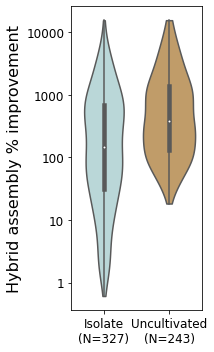

In [7]:
graph = Graph(sdf)
graph.sns.violinplot(x="cat_gtdb", y='log_improvement', cut=0, palette=cpal[1:])

def reverse_log(ticklabel) :
    text = ticklabel.get_text()
    print (ticklabel, text)
    try : value = int(text)
    except ValueError : return text
    return 10 ** value

graph.ax.set_yticklabels((10 ** graph.ax.get_yticks()).astype(int))
graph.add_xticks_ncount("cat_gtdb")

graph.ax.set_xlabel("")
graph.ax.set_ylabel("Hybrid assembly % improvement", size=16)

graph.apply_xticklabels(size=12)
graph.apply_yticklabels(size=12)

graph.set_size_inches(3, 5)
graph.tight_layout()

## Figure 1.G

In [8]:
def select(values):
    values = set(values)
    if 'HIGH' in values: return 'HIGH'
    elif 'NC' in values: return 'MEDIUM'
    elif 'MEDIUM' in values: return 'MEDIUM'
    raise Exception(values)

qhyb = df.groupby('reference')['qual_hybrid'].apply(select)

sdf = df.drop_duplicates('reference')[['reference', 'qual_gtdb', 'cat_gtdb']]
sdf['qual_hybrid'] = sdf['reference'].map(qhyb)

sdf

,reference,qual_gtdb,cat_gtdb,qual_hybrid
0,GCA_900552455.1,MEDIUM,Uncultivated,MEDIUM
1,GCA_000432375.1,NC,Uncultivated,HIGH
2,GCF_000012845.1,HIGH,Isolate,HIGH
3,GCF_003269275.1,HIGH,Isolate,HIGH
4,GCF_001025135.1,NC,Isolate,HIGH
...,...,...,...,...
3998,GCA_900538475.1,NC,Uncultivated,MEDIUM
4005,GCA_900553545.1,MEDIUM,Uncultivated,MEDIUM
4023,GCF_002088015.1,HIGH,Isolate,HIGH
4054,GCF_000158195.2,HIGH,Isolate,MEDIUM


In [9]:
def qual_sub(qvalue):
    if qvalue == 'HIGH': return 'HIGH'
    elif qvalue == 'NC': return 'MEDIUM'
    elif qvalue == 'MEDIUM': return 'MEDIUM'
    else: raise Exception(qvalue)
    
sdf['qual_gtdb2'] = sdf['qual_gtdb'].apply(qual_sub)
sdf['qual_hybrid2'] = sdf['qual_hybrid'].apply(qual_sub)

sdf.head()

,reference,qual_gtdb,cat_gtdb,qual_hybrid,qual_gtdb2,qual_hybrid2
0,GCA_900552455.1,MEDIUM,Uncultivated,MEDIUM,MEDIUM,MEDIUM
1,GCA_000432375.1,NC,Uncultivated,HIGH,MEDIUM,HIGH
2,GCF_000012845.1,HIGH,Isolate,HIGH,HIGH,HIGH
3,GCF_003269275.1,HIGH,Isolate,HIGH,HIGH,HIGH
4,GCF_001025135.1,NC,Isolate,HIGH,MEDIUM,HIGH


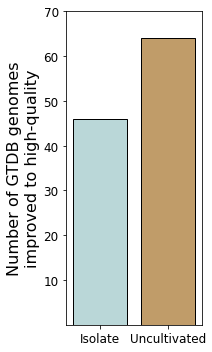

In [10]:
count = sdf[(sdf["qual_gtdb2"] == "MEDIUM") & (sdf["qual_hybrid2"] == "HIGH")]
count = count.groupby("cat_gtdb").size().rename("count").reset_index()

graph = Graph(count)
graph.sns.barplot(x="cat_gtdb", y="count", palette=cpal[1:], linewidth=1, edgecolor="black")

graph.ax.set_xlabel("")
graph.ax.set_ylabel("Number of GTDB genomes\nimproved to high-quality", size=16)

graph.apply_xticklabels(size=12)

yticks = [i for i in range(10, 80, 10)]
graph.ax.set_yticks(yticks)
graph.ax.set_yticklabels(yticks, size=12)

graph.set_size_inches(3, 5)
graph.tight_layout()

In [11]:
count

,cat_gtdb,count
0,Isolate,46
1,Uncultivated,64
